# Decision tree binary classifier using atmospheric data from Christman Field
[![Latest release](https://badgen.net/github/release/Naereen/Strapdown.js)](https://github.com/eabarnes1010/course_ml_ats/tree/main/code)
[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/eabarnes1010/course_ml_ats/blob/main/code/tree_classifier_binary_christman.ipynb)

* Iris example adapted from: https://www.datacamp.com/community/tutorials/random-forests-classifier-python
* Further modified by: Aaron Hill and Wei-Ting Hsiao (Dept. of Atmospheric Science, Colorado State University), January 2020
* Further adapted by: Prof. Elizabeth Barnes for ATS 780A7 Spring 2022 at Colorado State University

Lets import some libraries we will need throughout this tutorial:



In [1]:
try:
    import google.colab

    IN_COLAB = True
except:
    IN_COLAB = False
print("IN_COLAB = " + str(IN_COLAB))

IN_COLAB = False


In [2]:
import sys
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd
import datetime
import sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import export_graphviz
from sklearn.inspection import permutation_importance
import pydot
import matplotlib.pyplot as plt

# %matplotlib inline

In [3]:
print(f"python version = {sys.version}")
print(f"numpy version = {np.__version__}")
print(f"scikit-learn version = {sklearn.__version__}")

python version = 3.10.10 | packaged by conda-forge | (main, Mar 24 2023, 20:12:31) [Clang 14.0.6 ]
numpy version = 1.23.2
scikit-learn version = 1.3.0


In [4]:
if IN_COLAB == True:
    try:
        from google.colab import drive

        drive.mount("/content/drive", force_remount=True)
        local_path = "/content/drive/My Drive/Colab Notebooks/"
    except:
        local_path = "./"
else:
    local_path = "../figures/"

# 1. Data Preparation

### 1.1 Data overview

We have stored a .csv file on a CSU drive, accessible via URL. This will be the basis for our tutorial. This file contains Fort Collins weather data from 2020, and we will use these data to predict the high temperature for a given day with a random forest regression model.  

In [5]:
# Read in data from url
url = "https://raw.githubusercontent.com/eabarnes1010/course_ml_ats/main/data/fccwx_data_2020.csv"
data = pd.read_csv(url, parse_dates=["Date"])
data["dayofyear"] = data["Date"].dt.dayofyear
data.reindex(index=data.index[::-1])

/var/folders/sw/7glfsp2j5w3cw43s572xlj9r0000gn/T/ipykernel_37553/4127529689.py:3: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data = pd.read_csv(url, parse_dates=["Date"])


,Date,Temp [C],RH [%],DewPt [C],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
8586,2020-01-01,-2.170,62.76,-8.315162,0.700,7,2.136,222,832.583,0.000,0.0,1
8585,2020-01-01,-2.304,59.01,-9.230945,1.295,191,3.724,191,831.717,0.000,0.0,1
8584,2020-01-01,-2.584,56.78,-9.984343,1.169,231,3.998,187,830.682,0.000,0.0,1
8583,2020-01-01,-3.807,67.52,-8.939013,0.744,145,3.567,260,829.882,0.028,0.0,1
8582,2020-01-01,-4.464,60.92,-10.869217,0.853,350,2.940,223,829.095,0.015,0.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...
4,2020-12-30,-7.118,78.45,-10.228470,0.534,279,1.333,264,0.000,0.017,0.0,365
3,2020-12-30,-8.140,81.80,-10.698280,0.385,54,1.392,230,0.000,0.017,0.0,365
2,2020-12-30,-10.010,80.40,-12.741851,0.404,106,1.803,328,825.593,0.068,0.0,365
1,2020-12-30,-9.990,76.70,-13.304007,0.591,8,2.156,336,830.078,0.040,0.0,365


Lets look at our data to see what we are working with

In [6]:
# Display first 5 rows
print("The shape of our features is:", data.shape)

The shape of our features is: (8587, 12)


In [7]:
# A handy tool in pandas: descriptive statistics for each column
data.describe()

,Date,Temp [C],RH [%],DewPt [C],Wind [m/s],WindDir [deg. N],Gust [m/s],GustDir [deg. N],Pressure [hPa],Solar [W/m^2[,Precip [mm],dayofyear
count,8587,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000,8587.000000
mean,2020-06-30 04:00:08.384767744,9.853770,51.615725,-1.660949,2.617602,202.304064,5.448292,205.797950,638.786884,174.151465,0.025527,182.166764
min,2020-01-01 00:00:00,-22.760000,4.516000,-24.897700,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,2020-03-30 00:00:00,0.959500,31.270000,-7.791443,1.174500,125.000000,2.920000,130.000000,787.782000,0.004000,0.000000,90.000000
50%,2020-06-27 00:00:00,9.450000,50.030000,-2.201700,1.979000,196.000000,4.234000,213.000000,839.103000,8.520000,0.000000,179.000000
75%,2020-10-02 00:00:00,18.355000,70.760000,4.480746,3.218000,302.000000,6.527000,306.000000,843.564000,302.350000,0.000000,276.000000
max,2020-12-30 00:00:00,37.190000,99.600000,18.229760,18.880000,359.000000,123.800000,359.000000,1075.830000,993.000000,6.858000,365.000000
std,NaN,11.175732,24.028539,7.805753,2.241303,104.342626,4.109189,105.626903,358.531686,251.666787,0.227308,106.252753


### 1.2 Targets and features

The pandas table is handy for a quick glance, but we need to organize some numpy arrays that separately contain our features and labels.

In [8]:
THRESHOLD_TEMP = 25
TARGET_VAR = "Temp [C]"

# Labels are the values we want to predict
labels = (data[TARGET_VAR] > THRESHOLD_TEMP).astype(int)
label_names = ("cold <" + str(THRESHOLD_TEMP) + "C", "warm >" + str(THRESHOLD_TEMP) + "C")

# Remove the labels from the features
# axis 1 refers to the columns
features = data.drop(TARGET_VAR, axis=1)

# Also remove DewPt and Date
features = features.drop("DewPt [C]", axis=1)  # comment out if you want the prediction task to be easy
features = features.drop("Date", axis=1)

# Saving feature names for later use
feature_list = list(features.columns)
print("Predictors = " + str(feature_list))

# Convert to numpy array
features = np.array(features)

Predictors = ['RH [%]', 'Wind [m/s]', 'WindDir [deg. N]', 'Gust [m/s]', 'GustDir [deg. N]', 'Pressure [hPa]', 'Solar [W/m^2[', 'Precip [mm]', 'dayofyear']


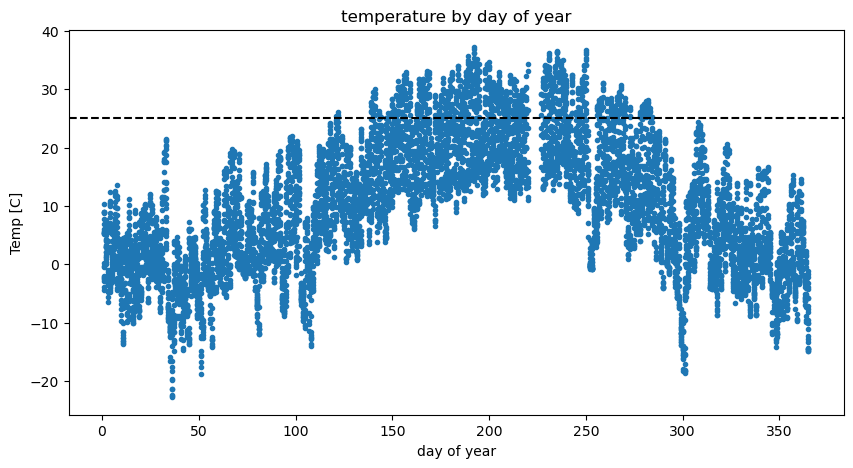

In [9]:
plt.figure(figsize=(10, 5))
plt.plot(features[:, -1], np.array(data[TARGET_VAR]), ".")
plt.axhline(y=THRESHOLD_TEMP, linestyle="--", color="k")
plt.xlabel("day of year")
plt.ylabel(TARGET_VAR)
plt.title("temperature by day of year")
plt.show()

As a best practice for classification tasks, always look at a histograms of your labels prior to moving on.

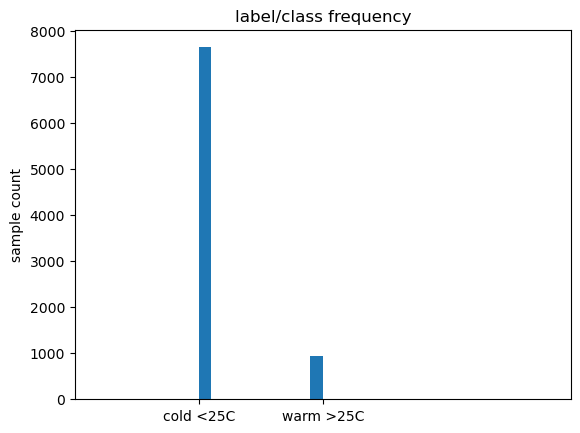

In [10]:
plt.figure()
plt.hist(labels)
plt.xticks(np.arange(0, len(label_names)), label_names)
plt.xlim(-1, 3)
plt.ylabel("sample count")
plt.title("label/class frequency")
plt.show()

### 1.3 Splitting training and testing datasets

Assuming we have no feature data available from 2019 we could use to test our trained models against, we will want to split up our dataset into training and testing portions. A standard proportion is 3/4 for training, 1/4 for testing, although this is somewhat arbitrary here. 

In [11]:
# Split the data into training and testing sets

# Tunable Parameter: Describes the proportion of the dataset we want to use for testing. 1 - split_size is used for training.
split_size = 0.25

# PARAMETERS:
#     test_size: fraction of testing/validation datasets
#     random_state: random parameter
train_features, val_features, train_labels, val_labels = train_test_split(
    features, labels, test_size=split_size, random_state=42
)

Lets quickly check the size of our training and testing arrays are what we expect (and we didn't do something wrong)

In [12]:
print("Training Features Shape:", train_features.shape)
print("Training Labels Shape:", train_labels.shape)
print("Validation Features Shape:", val_features.shape)
print("Validation Labels Shape:", val_labels.shape)

Training Features Shape: (6440, 9)
Training Labels Shape: (6440,)
Validation Features Shape: (2147, 9)
Validation Labels Shape: (2147,)


# 2. Creating a decision tree

### Train the model and visualize it

In [13]:
# SINGLE DECISION TREE

# Tunable Parameters for Model
tree_depth = 1
node_split = 2  # minimum number of training samples needed to split a node
leaf_samples = 1  # minimum number of training samples required to make a leaf node
RAND_STATE = 42

tree_clf = DecisionTreeClassifier(
    max_depth=tree_depth,
    min_samples_split=node_split,
    min_samples_leaf=leaf_samples,
    random_state=RAND_STATE,
    criterion="gini",  # can also set to 'entropy'
)
tree_clf.fit(train_features, train_labels)

DecisionTreeClassifier(max_depth=1, random_state=42)

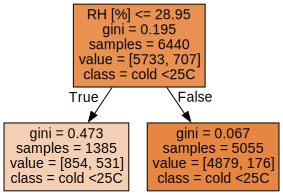

In [14]:
from graphviz import Source

fig_savename = "tree_classifier_christman"

if len(np.shape(tree_clf)) != 0:
    tree_to_viz = tree_clf[0]  # this line sets which decision tree out of your RF you want to plot
else:
    tree_to_viz = tree_clf
export_graphviz(
    tree_to_viz,
    out_file=local_path + fig_savename + ".dot",
    filled=True,
    proportion=False,
    leaves_parallel=False,
    class_names=label_names,
    feature_names=feature_list,
)
Source.from_file(local_path + fig_savename + ".dot")

### Make predictions

In [15]:
y_pred_train = tree_clf.predict(train_features)
y_pred_val = tree_clf.predict(val_features)
y_pred_val


array([0, 0, 0, ..., 0, 0, 0])

In [16]:
tree_clf.predict_proba(val_features)[:5]

array([[0.96518299, 0.03481701],
       [0.96518299, 0.03481701],
       [0.96518299, 0.03481701],
       [0.96518299, 0.03481701],
       [0.96518299, 0.03481701]])

### Visualization of predictions

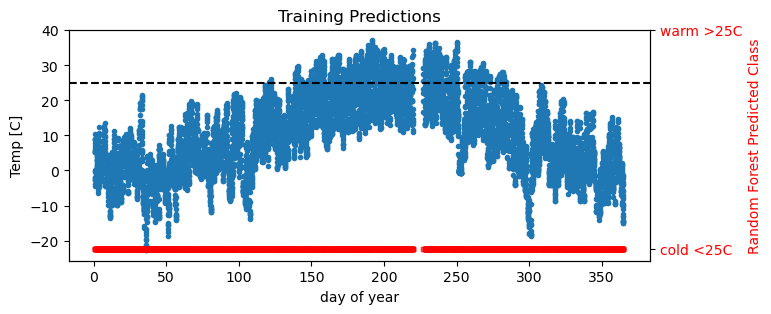

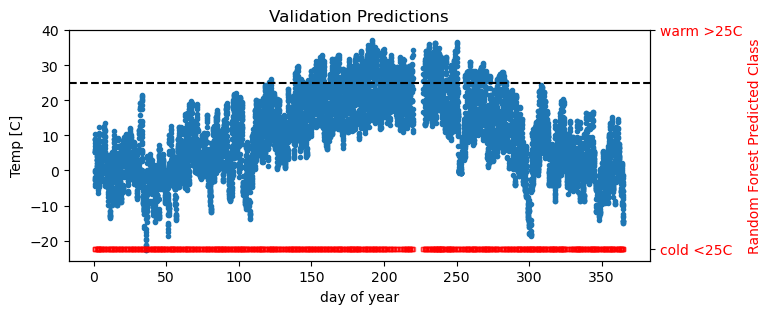

In [17]:
for split_type in ("Training", "Validation"):
    if split_type == "Training":
        plot_features = train_features
        plot_pred = y_pred_train
    elif split_type == "Validation":
        plot_features = val_features
        plot_pred = y_pred_val
    else:
        raise NotImplementedError()

    fig, ax1 = plt.subplots(figsize=(7.5, 3))
    ax2 = ax1.twinx()

    ax1.plot(features[:, -1], np.array(data[TARGET_VAR]), ".")
    ax1.axhline(y=THRESHOLD_TEMP, linestyle="--", color="k")
    ax1.set_xlabel("day of year")
    ax1.set_ylabel(TARGET_VAR)

    ax2.plot(
        plot_features[:, -1],
        plot_pred,
        "s",
        markersize=3,
        alpha=0.3,
        linewidth=0.1,
        markeredgecolor="r",
        markerfacecolor="None",
    )
    ax2.set_yticks(np.arange(0, len(label_names)))
    ax2.set_yticklabels(label_names, color="r")
    ax2.set_ylabel("Random Forest Predicted Class", color="r")

    plt.title(split_type + " Predictions")
    plt.show()

### Evaluate the classification predictions

In [18]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

y_probs = tree_clf.predict_proba(val_features)
y_scores = y_probs[:, 1]
fpr_tree, tpr_tree, thresholds_tree = roc_curve(val_labels, y_scores)
auc_tree = roc_auc_score(val_labels, y_scores)


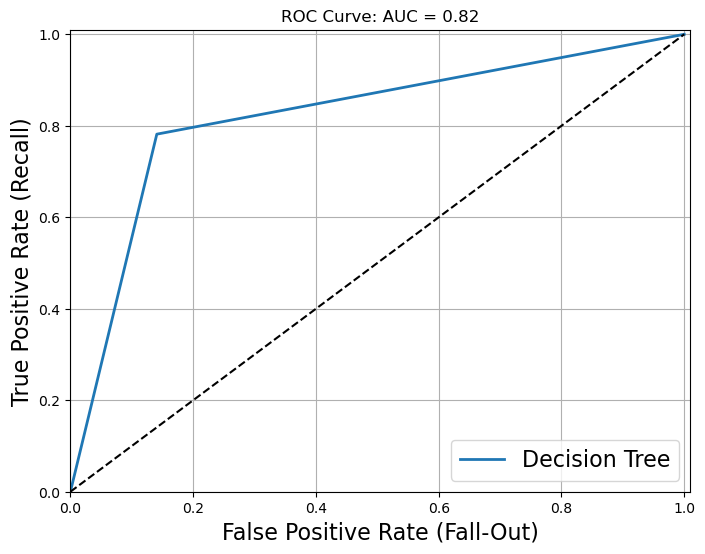

In [19]:
def plot_roc_curve(fpr, tpr, label=None):
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], "k--")  # dashed diagonal
    plt.axis([0, 1.01, 0, 1.01])  # Not shown in the book
    plt.xlabel("False Positive Rate (Fall-Out)", fontsize=16)  # Not shown
    plt.ylabel("True Positive Rate (Recall)", fontsize=16)  # Not shown
    plt.grid(True)  # Not shown


plt.figure(figsize=(8, 6))
plot_roc_curve(fpr_tree, tpr_tree, "Decision Tree")
plt.title("ROC Curve: AUC = " + str(auc_tree.round(3)))
plt.grid(True)
plt.legend(loc="lower right", fontsize=16)
plt.show()

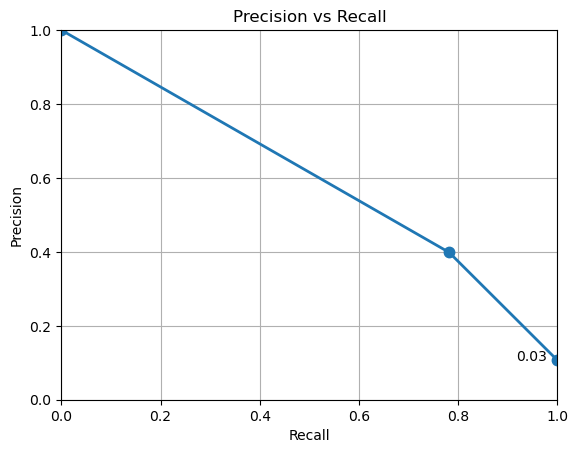

In [20]:
# Precision vs Recall Curve
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(val_labels, y_scores)
plt.plot(recalls, precisions, linewidth=2, linestyle="-", marker=".", markersize=15, label="Precision/Recall curve")
for i in np.arange(0, len(thresholds), 2):
    plt.text(recalls[i]-.02, precisions[i], thresholds[i].round(2), ha="right")
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.axis([0, 1, 0, 1])
plt.title("Precision vs Recall")
plt.grid()


training confusion matrix
[[5733    0]
 [ 707    0]]
validation confusion matrix
[[1918    0]
 [ 229    0]]


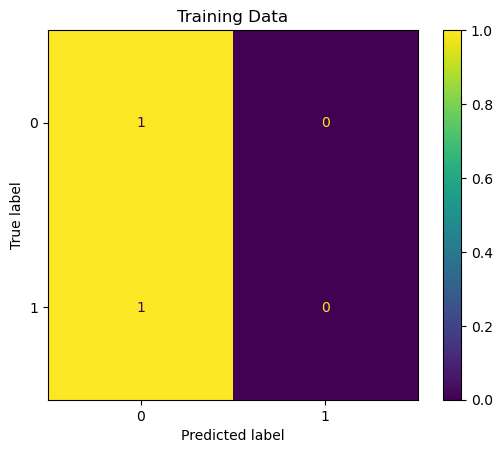

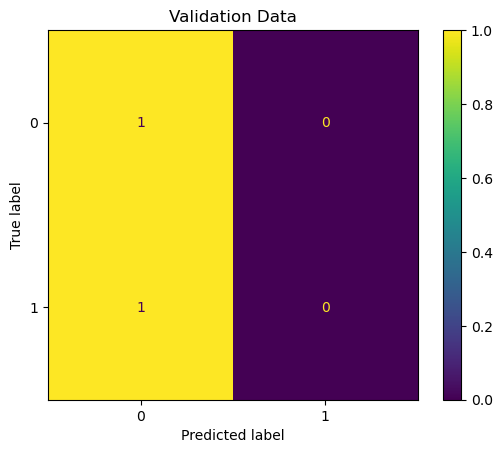

In [21]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

y_pred_train = tree_clf.predict(train_features)
print("training confusion matrix")
print(confusion_matrix(train_labels, y_pred_train))

y_pred_val = tree_clf.predict(val_features)
print("validation confusion matrix")
print(confusion_matrix(val_labels, y_pred_val))

ConfusionMatrixDisplay.from_predictions(train_labels, y_pred_train, normalize="true")
plt.title("Training Data")

ConfusionMatrixDisplay.from_predictions(val_labels, y_pred_val, normalize="true")
plt.title("Validation Data")
plt.show()


In [22]:
from sklearn.metrics import accuracy_score

print("Accuracy")
print(accuracy_score(train_labels, y_pred_train).round(3))
print(accuracy_score(val_labels, y_pred_val).round(3))

Accuracy
0.89
0.893


In [23]:
from sklearn.metrics import precision_score, recall_score

print("Precision")
print(precision_score(train_labels, y_pred_train, zero_division="warn"))
print(precision_score(val_labels, y_pred_val, zero_division="warn"))


Precision
nan
nan


In [24]:
print("Recall")
print(recall_score(train_labels, y_pred_train).round(3))
print(recall_score(val_labels, y_pred_val).round(3))


Recall
0.0
0.0


In [25]:
from sklearn.metrics import f1_score

print("Macro F1-Score")
print(f1_score(train_labels, y_pred_train, average="macro").round(3))
print(f1_score(val_labels, y_pred_val, average="macro").round(3))

print("")

print("Weighted F1-Score")
print(f1_score(train_labels, y_pred_train, average="weighted").round(3))
print(f1_score(val_labels, y_pred_val, average="weighted").round(3))

Macro F1-Score
0.471
0.472

Weighted F1-Score
0.839
0.843
